[//]: # REMOVE_FOR_WEBSITE
*Copyright 2023 Modular, Inc: Licensed under the Apache License v2.0 with LLVM Exceptions.*

[//]: # REMOVE_FOR_WEBSITE
# Mandelbrot in Mojo with Python plots


Not only is Mojo great for writing high-performance code, but it also allows us to leverage the huge Python ecosystem of libraries and tools. With seamless Python interoperability, Mojo can use Python for what it's good at, especially GUIs, without sacrificing performance in critical code. Let's take the classic Mandelbrot set algorithm and implement it in Mojo.

This tutorial shows two aspects of Mojo. First, it shows that Mojo can be used to develop fast programs for irregular applications. It also shows how we can leverage Python for visualizing the results.

In [1]:
#|code-fold: true
import benchmark
from math import iota
from sys import num_physical_cores
from algorithm import parallelize, vectorize
from complex import ComplexFloat64, ComplexSIMD
from python import Python

alias float_type = DType.float32
alias int_type = DType.int32
alias simd_width = 2 * simdwidthof[float_type]()
alias unit = benchmark.Unit.ms

First set some parameters, you can try changing these to see different results:

In [2]:
alias width = 960
alias height = 960
alias MAX_ITERS = 200

alias min_x = -2.0
alias max_x = 0.6
alias min_y = -1.5
alias max_y = 1.5

Here we define a simple `Matrix` struct:

In [3]:
@value
struct Matrix[type: DType, rows: Int, cols: Int]:
    var data: DTypePointer[type]

    fn __init__(inout self):
        self.data = DTypePointer[type].alloc(rows * cols)

    fn __getitem__(self, row: Int, col: Int) -> Scalar[type]:
        return self.data.load(row * cols + col)

    fn store[width: Int = 1](self, row: Int, col: Int, val: SIMD[type, width]):
        self.data.store[width=width](row * cols + col, val)

The core [Mandelbrot](https://en.wikipedia.org/wiki/Mandelbrot_set) algorithm involves computing an iterative complex function for each pixel until it "escapes" the complex circle of radius 2, counting the number of iterations to escape:

$$z_{i+1} = z_i^2 + c$$

In [4]:
# Compute the number of steps to escape.
def mandelbrot_kernel(c: ComplexFloat64) -> Int:
    z = c
    for i in range(MAX_ITERS):
        z = z * z + c
        if z.squared_norm() > 4:
            return i
    return MAX_ITERS


def compute_mandelbrot() -> Matrix[float_type, height, width]:
    # create a matrix. Each element of the matrix corresponds to a pixel
    matrix = Matrix[float_type, height, width]()

    dx = (max_x - min_x) / width
    dy = (max_y - min_y) / height

    y = min_y
    for row in range(height):
        x = min_x
        for col in range(width):
            matrix.store(row, col, mandelbrot_kernel(ComplexFloat64(x, y)))
            x += dx
        y += dy
    return matrix

Plotting the number of iterations to escape with some color gives us the canonical Mandelbrot set plot. To render it we can directly leverage Python's `matplotlib` right from Mojo!

First install the required libraries:

In [5]:
%%python
from importlib.util import find_spec
import shutil
import subprocess

fix = """
-------------------------------------------------------------------------
fix following the steps here:
    https://github.com/modularml/mojo/issues/1085#issuecomment-1771403719
-------------------------------------------------------------------------
"""

def install_if_missing(name: str):
    if find_spec(name):
        return
    print("missing", name)
    print(f"{name} not found, installing...")
    try:
        if shutil.which('python3'): python = "python3"
        elif shutil.which('python'): python = "python"
        else: raise ("python not on path" + fix)
        subprocess.check_call([python, "-m", "pip", "install", name])
    except:
        raise ImportError(f"{name} not found" + fix)

install_if_missing("numpy")
install_if_missing("matplotlib")

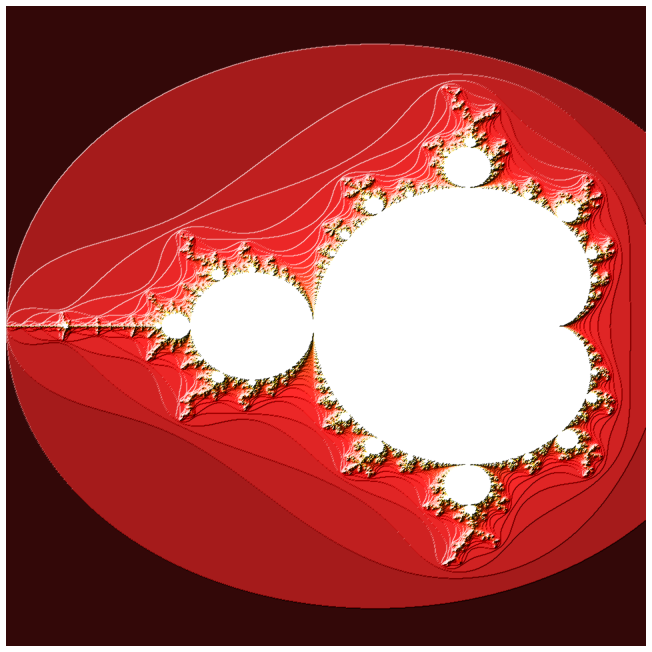

In [6]:
def show_plot[type: DType](matrix: Matrix[type, height, width]):
    alias scale = 10
    alias dpi = 64

    np = Python.import_module("numpy")
    plt = Python.import_module("matplotlib.pyplot")
    colors = Python.import_module("matplotlib.colors")

    numpy_array = np.zeros((height, width), np.float64)

    for row in range(height):
        for col in range(width):
            numpy_array.itemset((row, col), matrix[row, col])

    fig = plt.figure(1, [scale, scale * height // width], dpi)
    ax = fig.add_axes([0.0, 0.0, 1.0, 1.0], False, 1)
    light = colors.LightSource(315, 10, 0, 1, 1, 0)

    image = light.shade(numpy_array, plt.cm.hot, colors.PowerNorm(0.3), "hsv", 0, 0, 1.5)
    plt.imshow(image)
    plt.axis("off")
    plt.show()

show_plot(compute_mandelbrot())

## Vectorizing Mandelbrot
We showed a naive implementation of the Mandelbrot algorithm, but there are two things we can do to speed it up. We can early-stop the loop iteration when a pixel is known to have escaped, and we can leverage Mojo's access to hardware by vectorizing the loop, computing multiple pixels simultaneously. To do that we will use the `vectorize` higher order generator.

We start by defining our main iteration loop in a vectorized fashion

In [7]:
fn mandelbrot_kernel_SIMD[
    simd_width: Int
](c: ComplexSIMD[float_type, simd_width]) -> SIMD[int_type, simd_width]:
    """A vectorized implementation of the inner mandelbrot computation."""
    var cx = c.re
    var cy = c.im
    var x = SIMD[float_type, simd_width](0)
    var y = SIMD[float_type, simd_width](0)
    var y2 = SIMD[float_type, simd_width](0)
    var iters = SIMD[int_type, simd_width](0)

    var t: SIMD[DType.bool, simd_width] = True
    for _ in range(MAX_ITERS):
        if not t.reduce_or():
            break
        y2 = y * y
        y = x.fma(y + y, cy)
        t = x.fma(x, y2) <= 4
        x = x.fma(x, cx - y2)
        iters = t.select(iters + 1, iters)
    return iters

The above function is parameterized on the `simd_width` and processes simd_width pixels. It only escapes once all pixels within the vector lane are done. We can use the same iteration loop as above, but this time we vectorize within each row instead. We use the `vectorize` generator to make this a simple function call. The benchmark can run in parallel or just vectorized.

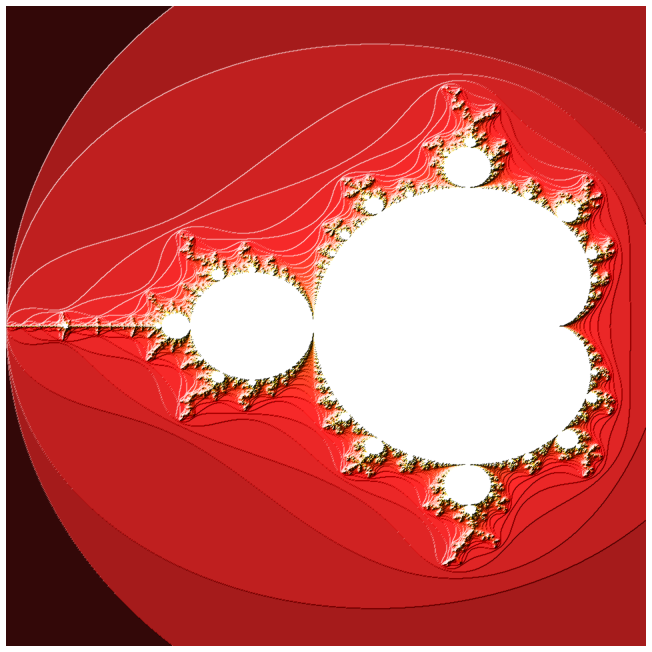


Vectorized: 13.224016129032258 ms


In [8]:
fn run_mandelbrot(parallel: Bool) raises -> Float64:
    var matrix = Matrix[int_type, height, width]()

    @parameter
    fn worker(row: Int):
        var scale_x = (max_x - min_x) / width
        var scale_y = (max_y - min_y) / height

        @parameter
        fn compute_vector[simd_width: Int](col: Int):
            """Each time we operate on a `simd_width` vector of pixels."""
            var cx = min_x + (col + iota[float_type, simd_width]()) * scale_x
            var cy = min_y + row * scale_y
            var c = ComplexSIMD[float_type, simd_width](cx, cy)
            matrix.store(row, col, mandelbrot_kernel_SIMD[simd_width](c))

        # Vectorize the call to compute_vector where call gets a chunk of pixels.
        vectorize[compute_vector, simd_width](width)

    @parameter
    fn bench():
        for row in range(height):
            worker(row)

    @parameter
    fn bench_parallel():
        parallelize[worker](height, height)

    var time: Float64 = 0
    if parallel:
        time = benchmark.run[bench_parallel](max_runtime_secs=0.5).mean(unit)
    else:
        time = benchmark.run[bench](max_runtime_secs=0.5).mean(unit)

    show_plot(matrix)
    matrix.data.free()
    return time

vectorized = run_mandelbrot(parallel=False)
print("Vectorized:", vectorized, unit)

## Parallelizing Mandelbrot
While the vectorized implementation above is efficient, we can get better performance by parallelizing on the cols. This again is simple in Mojo using the `parallelize` higher order function:

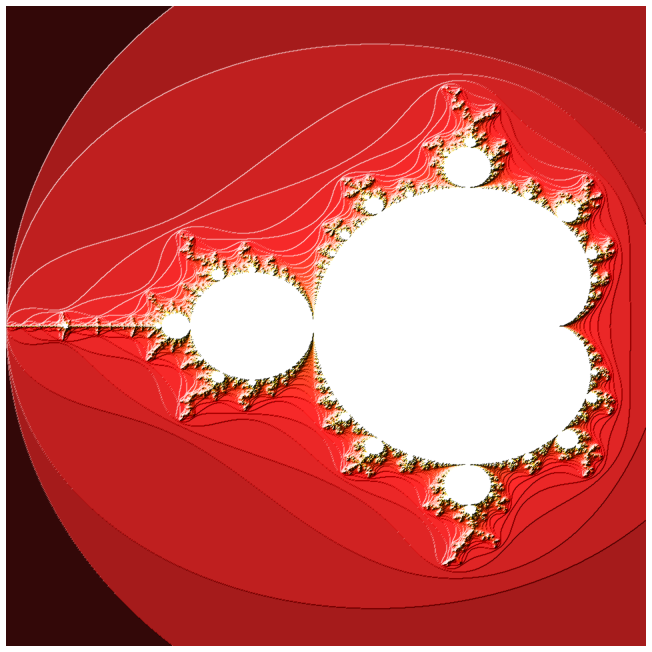


Parallelized: 2.1289554621848739 ms


In [9]:
parallelized = run_mandelbrot(parallel=True)
print("Parallelized:", parallelized, unit)

## Benchmarking

In this section we compare the vectorized speed to the parallelized speed 

In [10]:
print("Number of physical cores:", num_physical_cores())
print("Vectorized:", vectorized, "ms")
print("Parallelized:", parallelized, "ms")
#| CHECK: speedup
print("Parallel speedup:", vectorized / parallelized)

Number of physical cores: 12
Vectorized: 13.224016129032258 ms
Parallelized: 2.1289554621848739 ms
Parallel speedup: 6.2115043569116777
